# Techniques avancées d'apprentissage

**Auteurs** : Ryan Boustany, Paul Couairon

## Résumé

Ce code est inspiré de l'article de [Rui Jin & Aixin Tan](https://arxiv.org/pdf/1903.06964v1.pdf) paru en 2020, *Fast Markov chain Monte Carlo for high dimensional Bayesian regression models with shrinkage priors*.
Bien que les auteurs aient développé un package permettant d'exécuter leur modèle sous le langage R, le code suivant n'est **nullement** inspiré du code source fourni par les auteurs. Nous n'avons pas la prétention d'avoir implémenté le modèle en Python sans aucune erreur, mais nous essayons ici de nous appuyer sur les briques théoriques de l'article (que nous rappellerons au fur et à mesure).  
Il est nécessaire d'avoir installé `group_lasso` , `tensorflow` et `tensorflow_probability` pour la dernière partie de notre travail. Les autres librairies requises sont classiques : `numpy`, `scipy`, `matplotlib`.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Résumé" data-toc-modified-id="Résumé-1">Résumé</a></span></li>
<li><span><a href="#Premier-algorithme-:-l'algorithme-de-Gibbs-classique" data-toc-modified-id="Premier-algorithme-:-l'algorithme-de-Gibbs-classique-2">Premier algorithme : l'algorithme de Gibbs classique</a></span><ul class="toc-item"><li><span><a href="#L'algorithme" data-toc-modified-id="L'algorithme-2.1">L'algorithme</a></span></li></ul></li><li><span><a href="#Second-algorithme-:-Fast-Markov" data-toc-modified-id="Second-algorithme-:-Fast-Markov-3">Second algorithme : Fast Markov</a></span><ul class="toc-item"><li><span><a href="#L'algorithme" data-toc-modified-id="L'algorithme-3.1">L'algorithme</a></span></li><li><span><a href="#Visualisation-de-la-convergence" data-toc-modified-id="Visualisation-de-la-convergence-3.2">Visualisation de la convergence</a></span><ul class="toc-item"><li><span><a href="#Cas-de-p&lt;n-:-convergence-de-$\sigma^2$-et-$\beta$" data-toc-modified-id="Cas-de-p<n-:-convergence-de-$\sigma^2$-et-$\beta$-3.2.1">Cas de p&lt;n : convergence de $\sigma^2$ et $\beta$</a></span></li><li><span><a href="#Cas-de-p&gt;n-:-convergence-de-$\sigma^2$" data-toc-modified-id="Cas-de-p>n-:-convergence-de-$\sigma^2$-3.2.2">Cas de p&gt;n : convergence de $\sigma^2$</a></span></li></ul></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4">Evaluation</a></span></li><li><span><a href="#Comparaison-méthode-fréquentiste-et-bayésien-cas-p&gt;n" data-toc-modified-id="Comparaison-méthode-fréquentiste-et-bayésien-cas-p>n-5">Comparaison méthode fréquentiste et bayésien cas p&gt;n</a></span></li></ul></div>

## Introduction

Ce projet est inspiré de l'article de recherche de Rui Jin et Aixin Tan: _Fast Markov chain Monte Carlo for high dimensional Bayesian regression models with shrinkage priors_. 

Nous nous intéressons au modèle général de la régression linéaire à $p$ variables et $n$ exemples, qui est représenté comme suit:

$$
Y=X\beta^*+\varepsilon \quad \quad (1)
$$


où $\beta^*$ représente le vecteur des coefficients de la régression de taille $p\times1$, que nous souhaitons approcher, $X$ notre matrice de features, de taille $n\times p$, et enfin $\varepsilon$ un bruit gaussien, de taille $n\times1$. Dans notre cas, nous nous intéressons à un modèle **en grande dimension**, c'est-à-dire que $p$ est très grand, supérieur à $n$, voire grandement supérieur à $n$. L'approche standard pour résoudre ce genre de problème est d'utiliser la méthode de régression pénalisée LASSO, qui nous permet d'estimer de nombreuses valeurs de $\beta_j^*$ à des valeurs nulles. Il est intéressant de quantifier l'incertitude autour de l'estimation de ces coefficients. Une alternative est de proposer des modèles bayésiens, qui nous permettent de quantifier les incertitudes des paramètres et des variables latentes à travers les distributions _a posteriori_. Des méthodes classiques de Monte-Carlo comme celle du Gibbs Sampling nous permettent, grâce à ces distributions, d'approcher le vecteur d'intérêt $\beta^*$. Cependant, en grande dimension, la convergence de l'algorithme de Gibbs est peu satisfaisante. L'idée de R. Jin et A. Tan est de proposer un algorithme de Gibbs alternatif, requérant beaucoup moins de stockage à chaque itération. Dans ce projet, nous nous intéresserons à la comparaison de cet algorithme avec celui de Gibbs classique sur un modèle de **régression groupée**, c'est-à-dire que la matrice de features $X$ présente des groupes de colonnes avec de fortes corrélations. L'étude de ce type de problème n'est pas anodine : par exemple, en sciences sociales, si nous nous intéressons à plusieurs catégories de variables (liées à l'éducation etc.), un phénomène de corrélation intra-classes apparaîtra. Pour un problème de machine learning, le recodage de certaines variables qualitatives à l'aide d'un One-Hot Encoding fera apparaître de la corrélation dans chaque colonne liée à la variable catégorielle concernée. Dans le cadre de la régression groupée, l'estimateur LASSO est défini par :


 $$
 \hat{\beta}_{group}=\arg\min_\beta \left\lVert Y-\sum_{k=1}^K X_{G_k}\beta_{G_k} \right\rVert^2+\lambda\sum_{k=1}^K\left\lVert\beta_{G_k}\right\rVert_2 \quad \quad (2)
 $$
où $K$ correspond au nombre de classes (ou groupes) de variables de notre jeu de données, et $\beta_{G_k}$ et $X_{G_k}$ représentent respectivement les sous-matrices de coefficients et de features pour les classes concernées. 


## Frameworks et Objectifs
### Formalisation Bayésienne


En régression, l'approche bayésienne est généralement la même : elle consiste à proposer une distribution pour la vraisemblance du modèle, ainsi que des spécifications pour les distributions _a priori_ afin d'en déduire les distributions _a posteriori_ pour approcher le vecteur cible $\beta^*$. Pour les modèles en grande dimension, la spécificité que l'on souhaite préciser et qui est liée au _shrinkage_ (rétrecissement, contraction) fait l'objet d'un paramètre pour lequel on définit une loi _a priori_. Le modèle décrit ci-dessous correspond au modèle général utilisé dans le cadre d'estimation bayésienne pour la régression. 

\begin{align}
    Y\lvert\beta,\sigma^2&\sim\mathcal{N}_n(X\beta,\sigma^2 I_n)\\
    \beta\lvert\eta,\sigma^2&\sim\mathcal{N}_p(0,\sigma^2\Sigma_\eta) \quad \quad \quad (3)\\  
    \eta&\sim p(\eta)\\
    \sigma^2&\sim\text{Inverse-Gamma}(\alpha,\xi) 
\end{align}


où $Y$ et $X$ sont définis dans $(6)$, $\sigma^2$ correspond à la variance résiduelle eu modèle, et $\eta$ correspond au paramètre de _shrinkage_ dans notre cas. Les paramètres $\alpha, \xi$ concernent quant à eux la distribution à priori que l'on pose pour le paramètre $\sigma$. Dans le cas particulier de la **régression groupée**, R. Jin et A. Tan  proposent un cadre bayésien s'inscrivant dans le modèle proposé dans $(3)$: 

\begin{align*}
Y\lvert\beta,\sigma^2&\sim\mathcal{N}_n(X\beta,\sigma^2 I_n)\\
\beta_{G_k}\lvert\tau_k^2,\sigma^2&\stackrel{ind}{\sim}\mathcal{N}_p(0_{m_k},\sigma^2\tau_k^2I_{m_k}) \quad \quad (4) \\
\tau_k^2&\stackrel{ind}{\sim} \text{Gamma}\left(\frac{m_k+1}{2},\frac{\lambda^2}{2}\right)\\
\sigma^2&\sim\text{Inverse-Gamma}(\alpha,\xi) 
\end{align*}

où l'indice $k$ correspond au groupe concerné, $m_k$ est la taille du $k^e$ groupe, et $\tau$ correspond au paramètre de _shrinkage_ (l'équivalent de $\eta$ dans le modèle $(3)$. Notons que le rôle de la matrice $\sigma_nu$ est joué par $\tau_k^2 I_{m_k}$. Le paramètre $\tau_k$ est effectivement propre à chaque groupe ; il peut représenter la variance intra-groupe par exemple.
R. Jin et A. Tan montrent que sous le modèle $(3)$, on peut dériver les lois à posteriori suivantes : 

\begin{align*}
\frac{1}{\tau_k^2}\Big\lvert\beta,\sigma^2,Y&\stackrel{ind}{\sim}\text{Inverse-Gaussian}\left(\sqrt{\frac{\lambda^2\sigma^2}{\lVert\beta_{G_k}\rVert^2}},\lambda^2\right), \, k=1...K\\
\sigma^2\lvert\beta,\tau^2,Y&\sim\text{Inverse-Gamma}\left(\frac{n+p+2\alpha}{2},\frac{\lVert Y-X\beta\rVert_2^2+\beta^T D_\tau^{-1}\beta+2\xi}{2}\right) \quad \quad (5) \\
\beta\lvert \sigma^2,\tau^2,Y&\sim\mathcal{N}_p\left(\left(X^TX+D_\tau^{-1}\right)^{-1}X^TY,\sigma^2\left(X^TX+D_\tau^{-1}\right)^{-1}\right)
\end{align*}

où $D_\tau=\text{Diag}(\underset{m_1}{\underbrace{\tau_1^2,...,\tau_2^2}},\underset{m_1}{\underbrace{\tau_2^2,...,\tau_2^2}},...,\underset{m_K}{\underbrace{\tau_K^2,...,\tau_K^2}})=\tau_k^2 I_{m_k}$.

Maintenant que l'on possède un modèle bayésien précis, avec des distributions à posteriori connues, l'idée est d'appliquer les bonnes propriétés de l'inférence bayésienne dans le but d'approcher le vecteur cible à l'aide de ces lois.


### Objectifs
De la même manière que l'approche fréquentiste, on souhaite approcher un vecteur cible $\beta^*$. Dans notre approche, nous ne tentons pas de construire des estimateurs basés sur les observations empiriques de $X$ et $Y$ (des réalisations $((X_i,Y_i)_{i=1...n})$), mais de proposer des différentes lois à priori sur les paramètres, un modèle statistique (cette fois-ci grâce aux observations empiriques), d'en déduire les lois à posteriori et enfin de simuler ces dernières de nombreuses fois dans le but d'approcher la vraie distribution de $\beta$. L'algorithme classique utilisé pour ce genre de simulation est le Gibbs sampling, qui consiste en des tirages successifs selon les distributions à posteriori dans l'espoir que les paramètres convergent. On rappelle l'algorithme générique de Gibbs, pour deux paramètres $\beta$ et $\sigma$ que l'on souhaite estimer, suivant respectivement les distributions à posteriori $\pi(\beta\lvert X,Y,\sigma)$ et $\pi(\sigma\lvert X,Y,\beta)$ : 


<center>
<img src="gibbs_sampling.png"
alt="Markdown Monster icon"
width=700 /> 
</center>



Sous des conditions concernant les noyaux de transitions des deux distributions, il peut être montré que l'algorithme de gibbs sampling converge. Cependant, la convergence de l'algorithme ne peut être connue en amont ; le nombre d'itérations nécéssaires avant d'atteindre un voisinage autour de la solution peut être grand. L'objectif de R. Jin et A. Tan est de proposer une méthode **accélérée** de l'algorithme de gibbs sampling dans le but d'approcher le vecteur cible dans un contexte de grande dimension.

## Algorithmes

Le premier algorithme correspond à une application du Gibbs sampling adapté au cadre $(5)$:

<center>
<img src="3BG.png"
alt="Markdown Monster icon"
width=700 /> 
</center>


Le second algorithme est une version modifiée de l'algorithme **3BG**, en modifiant la loi à posteriori pour $\sigma^2$. Les preuves concernant les calculs de cette distribution _a posteriori_ peuvent être trouvées dans le supplementary material fourni par les auteurs de l'article.



<center>
<img src="2BG.png"
alt="Markdown Monster icon"
width=700 /> 
</center>



Il est important de comprendre que pour **2BG**, les tirages de $\sigma^2$ et $\beta$ ne sont pas les mêmes que pour 3BG. En effet, R. Jin et A. Tan proposent une alternative pour la distribution _a posteriori_ de $\sigma^2$, qui ne repose plus sur le vecteur $\beta$ entièrement ; en ce sens, la densité de transition de la chaîne de Markov liée à $(\sigma^2,\beta)$ ne nécessite plus un calcul prenant en compte $\beta$ pour la distribution conditionnelle, ce qui allège le temps de calcul. De plus, le paramètre de l'inverse-Gaussienne est pris en se concentrant sur le $K^e$ groupe de variables.

## Données Simulées

Nous avons décidé de tester nos algorithmes sur des données simulées selon un schéma proposé par les auteurs, afin de prendre en compte l'idée de "groupes" dans la matrice de features. On rappelle le modèle général donné dans $(6)$ : 

\begin{equation}
Y=X\beta^*+\varepsilon \quad \quad (6)
\end{equation}

Notre objectif est de travailler en grande dimension et de s'intéresser à l'évolution des performances de nos algorithmes lorsque $\frac{p}{n}$ devient de plus en plus grand. D'autre part, on souhaite dans notre cas prendre en compte la présence de corrélation intra-groupes. Notons $n$ la taille de l'échantillon d'entrée, et $K$ un élément de l'ensemble $\mathcal{K}=\{5,6,7,8,9,10,20,30,40,50\}$ (on le fera varier dans nos expériences). Pour la simulation de la matrice de features, R. Jin et A. Tan proposent la démarche suivante : 

* Simuler une matrice intermédiaire $A$ de taille $n\times K$ formée de $K$ colonnes de lois $\mathcal{N}_K(0_K,I_K)$.
* Faire apparaître le phénomène de groupe en stackant à la suite de chaque colonne, les colonnes contenant ses valeurs au carré, au cube, puissance $4$ et puissance $5$.
* On pose alors $X$ comme étant cette matrice-là, donc de la forme : 
    $$
    X=\begin{pmatrix}
    X_{11}  & X_{11}^2 & \cdots & \cdots & X_{11}^5 & \cdots & \cdots  X_{1K} & X_{1K}^2 & \cdots & X_{1K}^5 \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ 
    X_{n1}  & X_{n1}^2 & \cdots & \cdots & X_{n1}^5 & \cdots & \cdots  X_{nK} & X_{nK}^2 & \cdots & X_{nK}^5 \\ 
    \end{pmatrix}
    $$

Une fois la matrice $X$ simulée, nous générons $\beta^*$ selon un vecteur aléatoire suivant une loi de Student pour les $K$ premières coordonnées et des $0$ sur les $4K$ coordonnées suivant. Puis on génère un réel positif $\sigma^*$ (généralement pas plus grand que 2).
Finalement, on peut générer $Y$ tel que $Y=X\beta^*+\varepsilon$ avec $\varepsilon \sim \mathcal{N}_n(0_n,\sigma^* I_n)$.


À noter que l' algorithme $2BG$ prend en entrée les éléments suivant : 

* $X$ : de taille $n\times p$, $p=5K$.
* $Y$ : de taille $n\times 1$.
* $group\_size$ : nombre d'individus par groupe (dans notre cas $5$).
* $\beta$ : initiatlisation du vecteur $\beta$.
* $\sigma^2$ : initiatlisation du vecteur $\sigma^2$.
* $\lambda$ : hyperparamètre. 
* $\alpha$ :  hyperparamètre. 
* $\xi$ :  hyperparamètre. 
* $n_{iter}$ : nombre d'itérations.



In [1]:
!pip install group_lasso

In [2]:
import numpy as np
import math
import pandas as pd
from scipy.linalg import cho_factor, cho_solve
import numpy.polynomial.polynomial as nppol
import matplotlib.pyplot as plt
from scipy import array, linalg, dot
from scipy.stats import invgamma
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt 
from scipy.stats import gamma
from scipy.stats import invgauss
from scipy.stats import t
from numpy import linalg
from sklearn.metrics import r2_score
from group_lasso import GroupLasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

%matplotlib inline

np.random.seed(0)
GroupLasso.LOG_LOSSES = True

In [3]:
def X_build(n,K):
    X=np.zeros([n,5*K])
    mean = np.zeros(K)
    cov = np.eye(K)
    A=np.random.multivariate_normal(mean, cov, n)
    for i in range(0,K):
        A5=nppol.polyval(A[:,i], [0,0,0,0,0,1])
        A4=nppol.polyval(A[:,i], [0,0,0,0,1,0])
        A3=nppol.polyval(A[:,i], [0,0,0,1,0,0])
        A2=nppol.polyval(A[:,i], [0,0,1,0,0,0])
        A1=nppol.polyval(A[:,i], [0,1,0,0,0,0])
        X[:,i*5]= A1
        X[:,i*5+1]= A2
        X[:,i*5+2]= A3
        X[:,i*5+3]= A4
        X[:,i*5+4]= A5
    
    return X

sigma_true = 0.11

In [4]:
def rrinvgauss(n, mu, lambd): # simulation loi inverse gaussienne
    random_vector =  np.zeros(n)
    
    if mu > 1e6 :
        random_vector = pow(np.random.multivariate_normal(1, 0, 1), -2)
    else : 
        for i in range(0 , n):
            z = np.random.normal(0,1)
            y = z*z
            x = mu+0.5*mu*mu*y/lambd - 0.5*(mu/lambd)*math.sqrt(4*mu*lambd*y+mu*mu*y*y)
            u= np.random.uniform(0,1)
            if u <= mu/(mu+x) :
                random_vector[i] = x
            else :
                random_vector[i] = mu*mu/x
    return random_vector
                

In [5]:
def reptest(x,y):
    return np.repeat(x, y, axis=0)

## Premier algorithme : l'algorithme de Gibbs classique

### L'algorithme

On rappelle l'algorithme général nommé 3BG dans le papier de [R. Tin et A.Tan](https://arxiv.org/pdf/1903.06964v1.pdf). 

For $i=1...n$ :  
- draw $\displaystyle \frac{1}{{\tau_k^2}^{[i]}}\Big\lvert\beta,{\sigma^2}^{[i-1]},Y\stackrel{ind}{\sim}\text{Inverse-Gaussian}\left(\sqrt{\frac{\lambda^2{\sigma^2}^{[i-1]}}{\lVert{\beta_{G_k}}^{[i-1]}\rVert^2}},\lambda^2\right), \, k=1...K$  
- draw $\displaystyle {\sigma^2}^{[i]}\lvert\beta,\tau^2,Y\sim\text{Inverse-Gamma}\left(\frac{n+p+2\alpha}{2},\frac{\lVert Y-X{\beta}^{[i]}\rVert_2^2+{\beta^T}^{[i]} {D_\tau^{-1}}^{[i]}{\beta}^{[i]}+2\xi}{2}\right)$  
- draw $\displaystyle \beta^{[i]}\lvert \sigma^2,\tau^2,Y\sim\mathcal{N}_p\left(\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}X^TY,{\sigma^2}^{[i]}\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}\right)$  

Return $(\beta^{[n]},{\sigma^2}^{[n]})$

Pour la ditribution inverse gaussienne, nous l'avons codée "à la main", dans la fonction `rrinvgauss`. Les distributions normales et inverse gamma seront appelées grâce aux fonctions `random.multivariate_normal` et `gamma` déjà codées sur Python.  
La fonction suivante `iter_bg_gibbs` nous permet d'effectuer **une étape** de l'algorithme 3BG. La fonction qui vient ensuite, `3bg`, effectue le Gibbs sampling en appelant la fonction `iter_bg_gibbs` un nombre fini de fois, qui est donné par l'argument `n_iter`. 

In [6]:
def iter_bg_gibbs(beta, sigma2, X, Y, alpha, xi, n, p, lambd, group_size):
    group_size=group_size.astype(int)
    k = len(group_size)
    beta_l2 = np.zeros(k)
    start = 0
    for i in range(0,k):
        end = start + group_size[i] - 1
        beta_i = beta[int(start):int(end)] # calcul les normes de Beta_i de chaque groupe
        beta_l2[i] = np.sum(np.square(beta_i))
        start = start + group_size[i]
        
    # Simulation de 1/tau^2 qui suit une inverse gaussienne
    # on l'appelle tau pour la lisibilité
    
    tau_inv = np.zeros(k)
    for i in range(0,k):
        mu = math.sqrt((lambd**(2)) * sigma2 / beta_l2[i]) # mu de l'inverse gaussian de 1/tau
        betai = rrinvgauss(1, mu, lambd**(2))
        #betai = invgauss.rvs(mu,lambd**(2), size=1)
        tau_inv[i] = betai
        
    # Création du vecteur tau^2 =(tau_1^2,...,tau_k^2)
    tau_inv_f = np.zeros(p)
    tau_inv_f = reptest(tau_inv, group_size)
    tau = 1 / tau_inv_f
    
    D_tau_inv = np.diag(tau_inv_f)
    
    
    # Simulation de sigma au carré (on l'appelle sigma ici):

    mean_sigma = (n+p+2*alpha)/2
    part1 = np.linalg.norm(Y - X @ beta)**2
    cov_sigma = (part1 + beta.T @ D_tau_inv @ beta + 2*xi)/2 
    sigma_new = 1/gamma.rvs(mean_sigma, loc=0, scale = 1/cov_sigma, size=1)
    #sigma_new = invgamma.rvs(mean_sigma, loc=0, scale = cov_sigma, size=1)
        
    
    # Simulation de beta :
    term = np.linalg.inv(X.T @ X + D_tau_inv)
    mean_beta =  np.dot(term , X.T @ Y)
    cov_beta =  sigma_new*term
    beta_new = np.random.multivariate_normal(mean_beta,cov_beta, 1, tol=1e-6)
    
    
    res = np.zeros(p+1)
    res[0 : p] = beta_new
    res[p] = sigma_new
    
    return res

In [7]:
def bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter):
    
    n = X.shape[0]
    p = X.shape[1]
    betas = np.zeros([n_iter+1, p])
    betas[0] = beta
    sigma2s = np.zeros(n_iter+1)
    sigma2s[0] = sigma2
    for i in range(1,n_iter+1) :
        itera = iter_bg_gibbs(beta, sigma2, X, Y, alpha,xi, n, p, lambd, group_size)
        beta = itera[0:p]
        sigma2 = itera[p]
        sigma2s[i] = sigma2
        betas[i] = beta
 
    return betas,sigma2s

## Second algorithme : Fast Markov 

### L'algorithme

For $i=1...n$:  
- draw $\displaystyle \frac{1}{{\tau_k^2}^{[i]}}\Big\lvert\beta,\sigma^2,Y\stackrel{ind}{\sim}\text{Inverse-Gaussian}\left(\sqrt{\frac{\lambda^2{\sigma^2}^{[i-1]}}{\lVert{\beta_{G_K}}^{[i-1]}\rVert^2}},\lambda^2\right), \, k=1...K$
  
- draw 
    - $\displaystyle {\sigma^2}^{[i]}\lvert\beta,\tau^2,Y\sim\text{Inverse-Gamma}\left(\frac{n}{2}+\alpha,\frac{Y^T(I_n-X(X^TX+D_\tau^{-1})^{-1}X^T)Y}{2}+\xi\right)$
    - $\displaystyle \beta^{[i]}\lvert\sigma^2,\tau^2,Y\sim\mathcal{N}_p\left(\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}X^TY,{\sigma^2}^{[i]}\left(X^TX+{D_\tau^{-1}}^{[i]}\right)^{-1}\right)$ 

Return $(\beta^{[n]},{\sigma^2}^{[n]})$

In [8]:
def iter_bgl_fast(beta, sigma2, X, Y, alpha, xi, n, p, lambd, group_size):
    group_size=group_size.astype(int)
    k = len(group_size)
    beta_l2_k = np.sum(np.square(beta[int(len(beta)-k):int(len(beta))]))
    
        
    # Simulation de 1/tau^2 qui suit une inverse gaussienne
    # on l'appelle tau pour la lisibilité
    
    tau_inv = np.zeros(k)
    for i in range(0,k):
        mu = math.sqrt((lambd**(2)) * sigma2 / beta_l2_k) # mu de l'inverse gaussian de 1/tau
        betai = rrinvgauss(1, mu, lambd**(2))
        #betai = invgauss.rvs(mu,lambd**(2), size=1)
        tau_inv[i] = betai
       
    
    # Création du vecteur tau^2 =(tau_1^2,...,tau_k^2)
    
    tau_inv_f = np.zeros(p)
    tau_inv_f = reptest(tau_inv, group_size)
    tau = 1 / tau_inv_f
    
    D_tau_inv = np.diag(tau_inv_f)
    
    
    # Simulation de sigma :

    mean_sigma = (n + 2*alpha)/2
    part1 = np.linalg.inv(np.dot(X.T , X)+ D_tau_inv) #(25,25)
    part2 = np.eye(n) - np.dot(X , np.dot(part1 , X.T)) #(50,50)
    part3 = np.dot(Y.T,part2) 
    part4 = np.dot(part3 , Y)
    cov_sigma = (part4)/2 + xi
    sigma_new = 1/gamma.rvs(mean_sigma, loc=0, scale = 1/cov_sigma, size=1)
    #sigma_new = invgamma.rvs(mean_sigma, loc=0, scale = cov_sigma, size=1)
        
    
    # Simulation de beta :
    
    XTY = np.dot(X.T , Y)
    mean_beta =  np.dot(part1 , XTY)
    cov_beta =  sigma_new*part1
    beta_new = np.random.multivariate_normal(mean_beta,cov_beta, 1, tol=1e-6)
    
    
    res = np.zeros(p+1)
    res[0 : p] = beta_new
    res[p] = sigma_new
    
    return res

In [9]:
def bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter):
    
    n = X.shape[0]
    p = X.shape[1]
    betas = np.zeros([n_iter+1, p])
    betas[0] = beta
    sigma2s = np.zeros(n_iter+1)
    sigma2s[0] = sigma2
    for i in range(1,n_iter+1) :
        itera = iter_bgl_fast(beta, sigma2, X, Y, alpha,xi, n, p, lambd, group_size)
        beta = itera[0:p]
        sigma2 = itera[p]
        sigma2s[i] = sigma2
        betas[i] = beta
 
    return betas,sigma2s

### Visualisation de la convergence

#### Cas de p<n : convergence de $\sigma^2$ et $\beta$

In [10]:
sigma_true = 0.11

n_iter = 500

## number of examples and features 
n=1000
K=10

## models hyperparameters
lambd = 0.001
alpha = 0
xi = 0
sigma2 = 1

X=X_build(n,K) 
p=X.shape[1]   #p=5*K
beta_true=np.zeros(p)
for i in range(0,K):
    beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
n=X.shape[0]
p=X.shape[1]
beta = np.ones(p)
group_size = 5*np.ones(shape=K).astype(int)

estimationbg3=bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)
estimationbg2=bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)

print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 3BG :',math.sqrt(estimationbg3[1][100]))
print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 2BG :',math.sqrt(estimationbg2[1][100]))

True sigma : 0.11 Final sigma from the Markov chain 3BG : 0.1073012025893941
True sigma : 0.11 Final sigma from the Markov chain 2BG : 0.10692933144900804


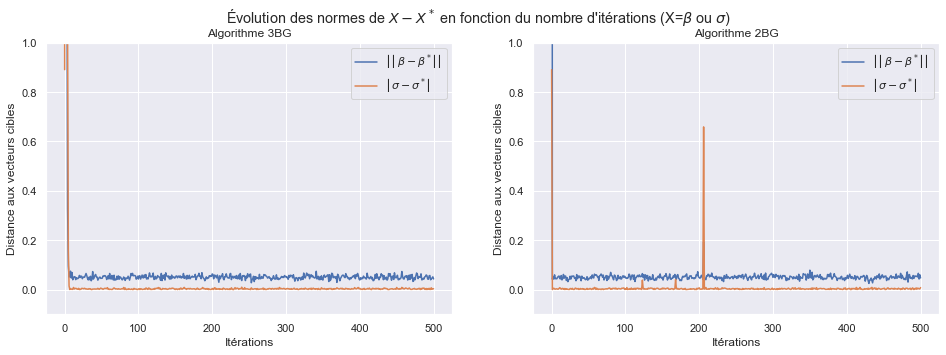

In [11]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle(r"Évolution des normes de $X-X^*$ en fonction du nombre d'itérations (X=$\beta$ ou $\sigma$)")

dif_beta = [estimationbg3[0][k] - beta_true for k in range(len(estimationbg3[0]))]
norms_beta = np.linalg.norm(dif_beta, axis=1)
dif_sigma = [math.sqrt(estimationbg3[1][k]) - sigma_true for k in range(len(estimationbg3[1]))]
norms_sigma = [np.linalg.norm(mat) for mat in dif_sigma]

ax[0].set_ylabel('Distance aux vecteurs cibles')
ax[0].set_xlabel('Itérations')
ax[0].plot(range(len(norms_beta)), norms_beta, label=r'$⎜⎜\beta-\beta^*⎜⎜$')
ax[0].plot(range(len(norms_sigma)), norms_sigma, label='$⎜\sigma-{\sigma}^*⎜$')
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-0.1,1])
ax[0].grid()
ax[0].legend()

dif_beta = [estimationbg2[0][k] - beta_true for k in range(len(estimationbg2[0]))]
norms_beta = np.linalg.norm(dif_beta, axis=1)
dif_sigma = [math.sqrt(estimationbg2[1][k]) - sigma_true for k in range(len(estimationbg2[1]))]
norms_sigma = [np.linalg.norm(mat) for mat in dif_sigma]

ax[1].set_ylabel('Distance aux vecteurs cibles')
ax[1].set_xlabel('Itérations')
ax[1].plot(range(len(norms_beta)), norms_beta, label=r'$⎜⎜\beta-\beta^*⎜⎜$')
ax[1].plot(range(len(norms_sigma)), norms_sigma, label='$⎜\sigma-{\sigma}^*⎜$')
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-0.1,1])
ax[1].grid()
ax[1].legend()

plt.show()

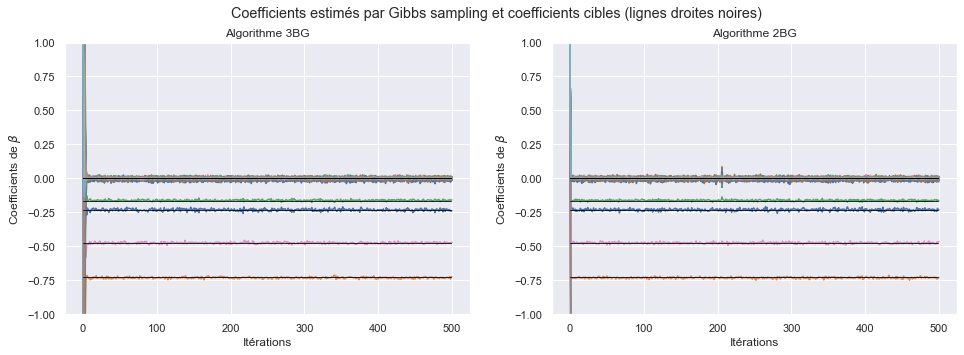

In [12]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle('Coefficients estimés par Gibbs sampling et coefficients cibles (lignes droites noires)')

axis = [np.array(beta_true) for k in range(n_iter)]

ax[0].set_ylabel(r'Coefficients de $\beta$')
ax[0].set_xlabel('Itérations')
ax[0].plot(estimationbg3[0], label='$\beta$')
ax[0].plot([np.array(beta_true) for k in range(n_iter)], color='black', linewidth=0.8)
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-1,1])
ax[0].grid()

ax[1].set_ylabel(r'Coefficients de $\beta$')
ax[1].set_xlabel('Itérations')
ax[1].plot(estimationbg2[0], label='$\beta$')
ax[1].plot([np.array(beta_true) for k in range(n_iter)], color='black', linewidth=0.8)
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-1,1])
ax[1].grid()

plt.show()

Dans notre exemple présent, nous avons exécuté les algorithmes $2BG$ et $3BG$ avec $n=1000$ et $p=50$. On note que les deux estimateurs ($\sigma$ et $\beta$) issu des deux algorithmes convergent bien et en peu d'itérations vers $\beta^*$ et $\sigma^*$. Cependant, rien ne nous permet de savoir quel algorithme semble le plus adapté à ce problème. 

### Cas en grande dimension
L'objectif principal de ce projet est d'étudier les simulations et le comportement des différents algorithmes. On ne regardera pas vraiment quels modèles ou quelles valeurs d'hyperparamètres correspondent le mieux à chaque scénario. Ainsi, nous présentons les résultats empiriques des modèles les plus raisonnables. Nous avons aussi décidé de fixer nous même les hyperparamètres en prenant $\alpha = \xi = 0$ et $\lambda = 1$.

#### Cas de $p>n$ : convergence de $\sigma^2$

In [13]:
sigma_true = 0.11

n_iter = 500

## number of examples and features 
n=100
K=40

## models hyperparameters
lambd = 1
alpha = 0
xi = 0
sigma2 = 1

X=X_build(n,K) 
p=X.shape[1]   #p=5*K
beta_true=np.zeros(p)
for i in range(0,K):
    beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
n=X.shape[0]
p=X.shape[1]
beta = np.ones(p)
group_size = 5*np.ones(shape=K).astype(int)

estimationbg3=bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)
estimationbg2=bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)

print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 3BG :',math.sqrt(estimationbg3[1][n_iter]))
print( 'True sigma :',sigma_true, 'Final sigma from the Markov chain 2BG :',math.sqrt(estimationbg2[1][n_iter]))

True sigma : 0.11 Final sigma from the Markov chain 3BG : 0.43070104532736364
True sigma : 0.11 Final sigma from the Markov chain 2BG : 0.28638548677025677


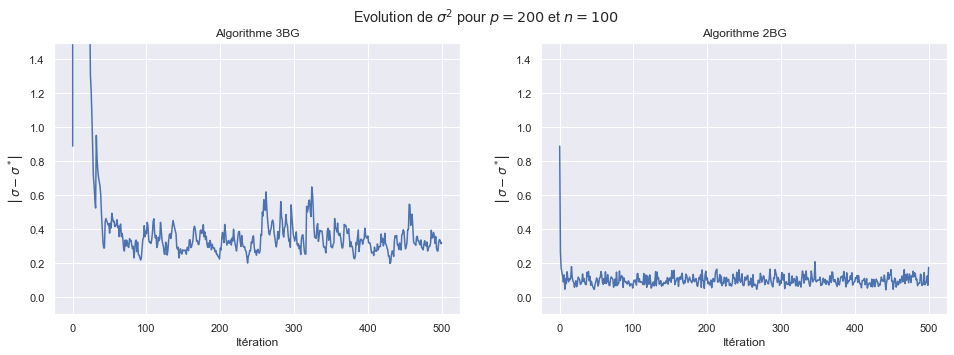

In [14]:
import seaborn as sns
sns.set(style='dark')

fig, ax = plt.subplots(1,2,figsize=(16,5))
plt.suptitle("Evolution de $\sigma^2$ pour $p=200$ et $n=100$")

dif_sigma = [math.sqrt(estimationbg3[1][k]) - sigma_true for k in range(len(estimationbg3[1]))]
norms_sigma = [abs(mat) for mat in dif_sigma]

ax[0].set_ylabel(r"$⎜\sigma-{\sigma}^*⎜$")
ax[0].set_xlabel('Itération')
ax[0].plot(range(len(norms_sigma)), norms_sigma)
ax[0].set_title('Algorithme 3BG')
ax[0].set_ylim([-0.1,1.5])
ax[0].grid()

dif_sigma = [math.sqrt(estimationbg2[1][k]) - sigma_true for k in range(len(estimationbg2[1]))]
norms_sigma = [abs(mat) for mat in dif_sigma]

ax[1].set_ylabel(r"$⎜\sigma-{\sigma}^*⎜$")
ax[1].set_xlabel('Itération')
ax[1].plot(range(len(norms_sigma)), norms_sigma)
ax[1].set_title('Algorithme 2BG')
ax[1].set_ylim([-0.1,1.5])
ax[1].grid()

plt.show()

Notons que nous avons modifié le paramètre $\lambda$ pour ce contexte.  
Les deux algorithmes nous donnent une approximation de l'écart-type. Au bout de $100^e$ itération, l'algorithme 2BG proposé par les auteurs atteint une approximation plus satisfaisante. Notons cependant que en changeant un hyperparamètre, un Sampler peut performer mieux que l'autre. Les résultats sont globalement comparables. En regardant l'évolution de la chaîne, l'algorithme Gibbs classique semble prendre plus de temps avant de se rapprocher de la valeur cible. 2BG semble plus direct.  
Il convient de nuancer ces résultats : la convergence est sensible au paramètre que nous posons sur l'a priori du paramètre de *shrinkage* $\tau$.  
Sachant à présent que nos deux algorithmes restent intéressants en grande dimension pour approcher l'écart-type (et donc la variance), l'idée de [R. Tin et A.Tan](https://arxiv.org/pdf/1903.06964v1.pdf) est d'évaluer, en termes de vitesse de convergence, les chaînes de Markov alors construites par les deux Gibbs samplers. Nous introduisons l'effective sampling size, donnée par : 

$$N_{eff}=\frac{N}{1+2\sum_{k=1}^\infty \rho_k}$$

L'effective sampling size est une estimation du nombre de tirages requis lors de l'algorithme afin d'atteindre le même niveau de précision que si le tirage était aléatoire. Il s'agit d'une mesure importante de l'efficacité d'une méthode de Monte-Carlo comme celles présentées par les algorithmes que les auteurs ont proposé.  Cette métrique évalue la qualité du tirage effectué par les algorithmes 2BG et 3BG à chaque itération. Numériquement, plus $N_{eff}$ est élevé, plus ceci indique une meilleure mixité de la chaîne puisqu'il s'agit d'une fonction décroissante des autocorrélations. 

## Evaluation

La métrique $N_{eff}$ est implémentée en temps que fonction `effective_sample_size` dans le module `tensorflow_probability` et correspond à la formule décrite juste au-dessus (voir https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/effective_sample_size). Comme le proposent les auteurs, nous allons également prendre le temps de calcul en considération et allons examiner non pas $N_{eff}$ mais $\displaystyle \frac{N_{eff}}{T}$, l'effective sample size moyen par seconde. Autrement dit, le temps de calcul de l'effective sample size est également pris en compte afin de normaliser les valeurs de $N_{eff}$ d'un algorithme à l'autre, mais également de donner un sens à la caractérisation dite "rapide" de l'algorithme 2BG proposé par les auteurs.

On va chercher à évaluer, pour chaque valeur de $p$, l'effective sample size de la chaîne de $\sigma^2$ induite par les algorithmes 2BG et 3BG. Les autocorrélations seront également évaluées afin de calculer la mixité des chaînes. R. Jin et A. Tan indiquent qu'une faible auto-corrélation implique une bonne mixitié de la chaîne induite et donc un meilleur mélange réalisé par l'algorithme.

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp

In [16]:
import timeit

autocorrs = []
effs = []
axis = []

lambd = 1
alpha = 0
xi = 0
sigma2 = 1

def metrics(n,n_iter):
    autocorrs1 = []
    effs1 = []
    autocorrs2 = []
    effs2 = []
    axis = []
    for K in [5,6,7,8,9,10,20,30,40,50]:

        X=X_build(n,K) #n=50 p=5*K
        p=X.shape[1]
        beta_true=np.zeros(p)
        for i in range(0,K):
            beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
        Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
        ## calculus of the autocorrelations of the Markov chain and effective sample size time computation
        
        n=X.shape[0]
        p=X.shape[1]
        beta = np.ones(p)
        group_size = 5*np.ones(shape=K).astype(int)
        
        # algorithm 2BG
        start = timeit.default_timer() # computation times of the Neff of the Hidden Markov chain
        estimation = bg2(X, Y, group_size, beta, sigma2,lambd, alpha, xi, n_iter)
        eff = tfp.mcmc.effective_sample_size(estimation[1]).numpy()
        stop = timeit.default_timer()
        
        s = pd.Series(estimation[1])
        autocorrs1.append(s.autocorr())# one lag autocorrelation of the chain
        effs1.append(eff/(stop-start)) # N_eff / T

        # algorithm 3BG
        start = timeit.default_timer() # computation times of the Neff of the Hidden Markov chain
        estimation = bg3(X, Y, group_size, beta, sigma2,lambd, alpha, xi, n_iter)
        eff = tfp.mcmc.effective_sample_size(estimation[1]).numpy()
        stop = timeit.default_timer()
        
        s = pd.Series(estimation[1])
        autocorrs2.append(s.autocorr())# one lag autocorrelation of the chain
        effs2.append(eff/(stop-start)) # N_eff / T
        axis.append(p/n)
        
    return axis,autocorrs1,effs1,autocorrs2,effs2

In [17]:
n = 50
n_iter = 500
axis,autocorrs2BG,effs2BG,autocorrs3BG,effs3BG = metrics(n,n_iter)

n = 100
n_iter = 500
axis_,autocorrs2BG_,effs2BG_,autocorrs3BG_,effs3BG_ = metrics(n,n_iter)

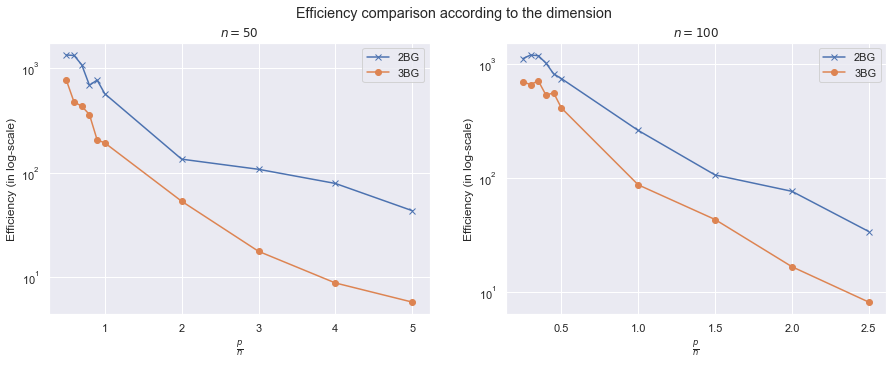

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Efficiency comparison according to the dimension')

ax[0].set_ylabel('Efficiency (in log-scale)')
ax[0].set_xlabel(r"$\frac{p}{n}$")
ax[0].plot(axis,effs2BG,label='2BG',marker='x')
ax[0].plot(axis,effs3BG,label='3BG',marker='o')
ax[0].legend()
ax[0].set_title('$n=50$')
ax[0].grid()
ax[0].set_yscale('log')
             
ax[1].set_ylabel('Efficiency (in log-scale)')
ax[1].set_xlabel(r"$\frac{p}{n}$")
ax[1].plot(axis_,effs2BG_,label='2BG',marker='x')
ax[1].plot(axis_,effs3BG_,label='3BG',marker='o')
ax[1].legend()
ax[1].set_title('$n=100$')
ax[1].grid()
ax[1].set_yscale('log')

Comme l'ont montré R. Jin et A. Tal, si les efficacités sont comparables pour $p<n$, l'écart se creuse lorsque $p$ devient plus grand que $n$. L'efficacité de l'algorithme 2BG est bien supérieure, sur les différents ranges $(p,n)$, pour 2BG par rapport à 3BG.  Les efficacités des algorithmes sont de plus en plus écartées pour $p$ plus grand que $n$, ce qui prouve la pertinence du nouveau modèle en particulier pour la grande dimension. Notons que les valeurs des *efficiencies* ne sont pas les mêmes, au niveau de l'échelle de $\displaystyle \frac{N_{eff}}{T}$, que dans l'article de R. Jin et A. Tan, à cause du temps de calcul $T$ qui n'est pas pareil au vu de la différence de puissance de nos machines. Les résultats restent cependant visibles car il s'agit d'une relation de proportionnalité.

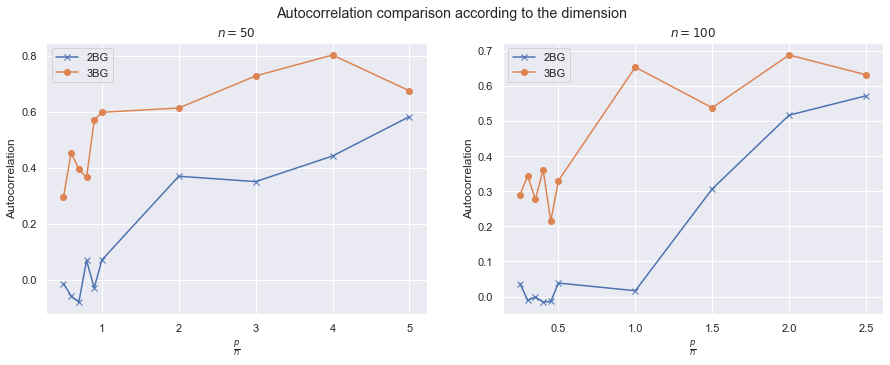

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plt.suptitle('Autocorrelation comparison according to the dimension')

ax[0].set_ylabel('Autocorrelation')
ax[0].set_xlabel(r"$\frac{p}{n}$")
ax[0].plot(axis,autocorrs2BG,label='2BG',marker='x')
ax[0].plot(axis,autocorrs3BG,label='3BG',marker='o')
ax[0].legend()
ax[0].set_title('$n=50$')
ax[0].grid()

             
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlabel(r"$\frac{p}{n}$")
ax[1].plot(axis_,autocorrs2BG_,label='2BG',marker='x')
ax[1].plot(axis_,autocorrs3BG_,label='3BG',marker='o')
ax[1].legend()
ax[1].set_title('$n=100$')
ax[1].grid()

plt.show()

On voit que l'algorithme 2BG présente des autocorrélations nettement inférieures à celles de la chaîne de l'algorithme 3BG, comme démontré par les auteurs dans l'article. Cet écart indique un meilleur mélange réalisé par l'algorithme 2BG.

## Comparaison méthode fréquentiste et bayésien cas p>n

On peut dans une ultime approche tenter de comparer les résultats que nous obtenons avec nos algorithmes de Gibbs issus de l'article de R. Jin et A. Tan avec la méthode fréquentiste. On va donc comparer les coefficients du vecteur $\beta$ trouvé par le Lasso (fréquentiste) avec notre estimateur 2BG implémenté plus haut (bayésien).

In [20]:
sigma_true = 1

n_iter = 500

## number of examples and features 
n=100
K=30

## models hyperparameters
lambd = 1
alpha = 0
xi = 0
sigma2 = 1

X=X_build(n,K) 
p=X.shape[1]   #p=5*K
beta_true=np.zeros(p)
for i in range(0,K):
    beta_true[i]=t.rvs(2, loc=0, scale=1, size=1, random_state=None)
        
Y = np.dot(X,beta_true) + np.random.normal(0, sigma_true, n)
    
n=X.shape[0]
p=X.shape[1]
beta = np.ones(p)
group_size = 5*np.ones(shape=K).astype(int)

estimationbg3=bg3(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)
estimationbg2=bg2(X,Y,group_size,beta,sigma2,lambd, alpha, xi, n_iter)


# possibilité de changer l'estimateur : on choisit 2BG ici.
beta_bayesien = estimationbg2[0][n_iter-1]
sigma_bayesien = estimationbg2[1][n_iter-1]

In [22]:
group_sizes = group_size
active_groups = [np.random.randint(2) for _ in group_sizes]
groups = np.concatenate(
    [size * [i] for i, size in enumerate(group_sizes)]
).reshape(-1, 1)

In [32]:
pipe = pipe = Pipeline(
    memory=None,
    steps=[
        (
            "variable_selection",
            GroupLasso(
                groups=groups,
                group_reg=0.1,
                l1_reg=0,
                scale_reg=None,
                supress_warning=True,
                n_iter=10000
            ),
        ),
        ("regressor", Ridge(alpha=5)),
    ],
)
pipe.fit(X, Y)

/opt/anaconda3/lib/python3.8/site-packages/group_lasso/_fista.py:114: ConvergenceWarning: The FISTA iterations did not converge to a sufficient minimum.
You used subsampling then this is expected, otherwise, try increasing the number of iterations or decreasing the tolerance.
  warnings.warn(


AttributeError: 'GroupLasso' object has no attribute 'frobenius_lipschitz'

AttributeError: 'GroupLasso' object has no attribute 'frobenius_lipschitz'

In [33]:
# Extract from pipeline
yhat = pipe.predict(X)
sparsity_mask = pipe["variable_selection"].sparsity_mask_
beta_frequentiste= pipe["regressor"].coef_.T
beta_frequentiste = np.concatenate((beta_frequentiste,np.zeros(p-len(beta_frequentiste))))



# Compute performance metrics
MSE_frequentiste = mean_squared_error(Y, yhat)
MSE_bayesien = mean_squared_error(Y, X@beta_bayesien)


print(f"Number variables: {len(sparsity_mask)}")
print(f"Number of chosen variables: {sparsity_mask.sum()}")
print(f"MSE bayesien: {MSE_bayesien}")
print(f"MSE fréquentiste: {MSE_frequentiste}")

Number variables: 150
Number of chosen variables: 150
MSE bayesien: 1.009178791558767
MSE fréquentiste: 6.835277694378759


In [34]:
norms_beta_bayesien = np.linalg.norm(beta_bayesien - beta_true)
norms_beta_frequentiste = np.linalg.norm(beta_frequentiste - beta_true)

print(f"Norme Beta True and Beta Bayesian: {norms_beta_bayesien}")
print(f"Norme Beta True and Beta Frequentiste: {norms_beta_frequentiste}")

Norme Beta True and Beta Bayesian: 36.269699179001215
Norme Beta True and Beta Frequentiste: 35.23493039594957


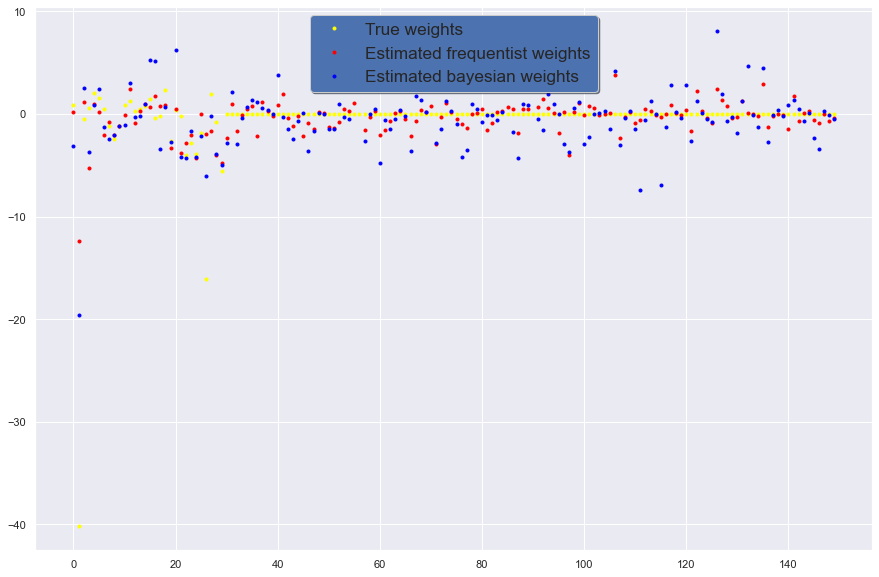

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(beta_true, ".", label="True weights",color='Yellow')
plt.plot(beta_frequentiste, ".", label="Estimated frequentist weights",color='Red')
plt.plot(beta_bayesien, ".", label="Estimated bayesian weights",color='Blue')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')
plt.grid()
plt.show()

On retrouve les premiers poids du vecteur cible qui sont non nuls et le reste étant nul. On remarque que les deux méthodes sont très proches en termes de résultats pour approcher le vecteur cible. Notre algorithme 2BG fonctionne bien, même en grande dimension, pour approcher le vecteur cible. Les deux approches ne sont cependant pas toujours parfaites ; cependant, l'approche bayésienne est tout à fait comparable à l'approche fréquentiste très classique. On obtient même une MSE inférieure pour notre méthode bayésienne implémentée que pour le GroupLasso. Notons cependant que notre algorithme reste très sensible aux hyperparamètres $\lambda$, $\alpha$, $\xi$, malgré nos bons résultats.

## Conclusion

Dans le modèle bayésien de type Group Lasso, la $2BG$ nous semble toujours plus efficace que la $3BG$. L'avantage majeur de la $2BG$ est lorsque le nombre de prédicteurs $p$ est supérieur à la taille de l'échantillon de données $n$. Dans ces problèmes de régression à haute dimension, la $2BG$ produit environ $10$ à $100$ fois plus d'échantillons efficaces par seconde que son concurrent. Le taux de mélange rapide de la $2BG$ et le faible coût de calcul par itération de la $2BG$, qui n'est pas supérieur à celui de la $3BG$, contribuent à cet avantage. 

Pour aller plus loin, une comparaison avec la méthode fréquentiste du GroupLasso classique, dont l'estimateur est donné par la formule $(2)$, est disponible dans notre Notebook Python joint à ce rapport. Nous verrons notamment que l'efficacité de notre méthode $2BG$ (et même $3BG$) dans le cas en grande dimension est largement comparable à l'estimateur fréquentiste, pour le cas de l'estimation de $\beta$ (pas seulement $\sigma$, paramètre sur lequel nous nous sommes intéressés pour le cas en grande dimension dans ce papier). 
